In [3]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

df = pd.read_csv("telecom_churn_smote.csv")
df

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.700000,1,265.100000,110,89.000000,9.870000,10.000000
1,0,107,1,1,3.700000,1,161.600000,123,82.000000,9.780000,13.700000
2,0,137,1,0,0.000000,0,243.400000,114,52.000000,6.060000,12.200000
3,0,84,0,0,0.000000,2,299.400000,71,57.000000,3.100000,6.600000
4,0,75,0,0,0.000000,3,166.700000,113,41.000000,7.420000,10.100000
...,...,...,...,...,...,...,...,...,...,...,...
5695,1,19,1,0,0.000000,1,314.261804,117,73.011850,10.964799,11.379763
5696,1,211,1,0,0.206264,2,229.003103,126,66.856242,14.848162,12.176882
5697,1,121,0,0,0.130437,2,239.327324,87,64.440986,12.903648,11.089437
5698,1,126,1,0,0.014430,2,250.246873,96,64.865007,12.892390,12.606901


In [5]:
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=14)

#### Random forest

##### Train model

In [64]:
rf = RandomForestClassifier(random_state=13)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=13)

In [65]:
y_pred = rf.predict(X_test)

In [66]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9263157894736842


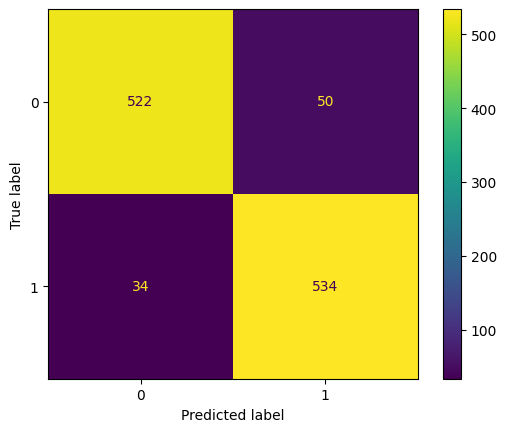

In [67]:

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

##### Hyperparameter tuning

In [68]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5,
                                 random_state=13)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FFABB11370>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FFABCFE120>},
                   random_state=13)

In [70]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 19, 'n_estimators': 226}


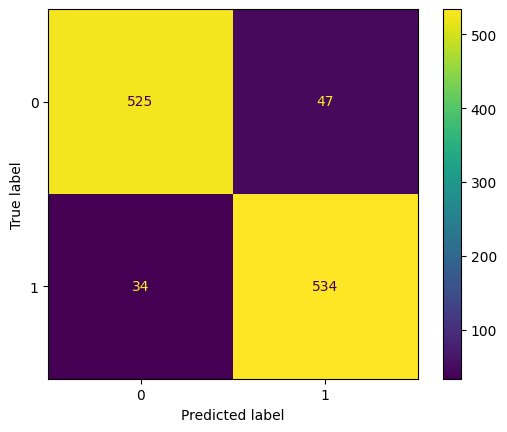

In [71]:
# Generate predictions with the best model
y_pred_best = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [72]:
accuracy = accuracy_score(y_test, y_pred_best)
print("Accuracy:", accuracy)

Accuracy: 0.9289473684210526


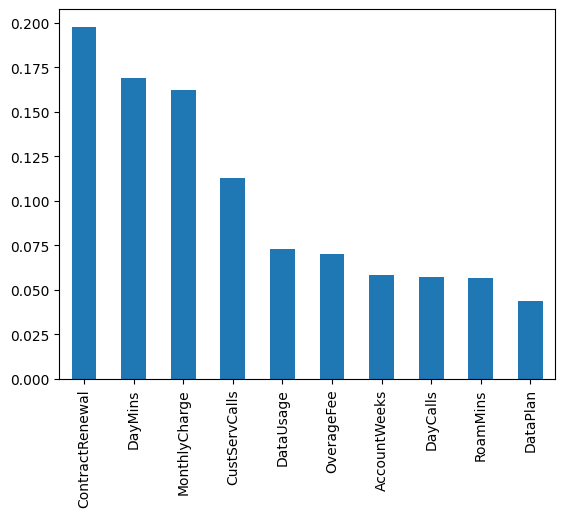

In [73]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

#### XGBoost 

##### Train model

In [12]:
import xgboost as xgb

# declare parameters
params = {
            'objective':'binary:logistic',
            'max_depth': 19,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':226,
            'seed':13
        }
            
            
            
# instantiate the classifier 
xgb_clf = xgb.XGBClassifier(**params)


# fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=19, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=226, n_jobs=None,
              num_parallel_tree=None, ...)

In [13]:
y_pred_xg = xgb_clf.predict(X_test)

In [14]:
accuracy = accuracy_score(y_test, y_pred_xg)
print(accuracy)

0.9210526315789473


##### Hyperparameter tuning

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
    'seed': 13
}


In [ ]:
def objective(space):
    clf=xgb.XGBClassifier(
                n_estimators=int(space['n_estimators']),
                max_depth=int(space['max_depth']),
                gamma=space['gamma'],
                colsample_bytree=float(space['colsample_bytree']),
                min_child_weight=int(space['min_child_weight']),
                eval_metric="auc",
                early_stopping_rounds=10,
                seed = 13
                )
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, 
            verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [88]:
trials = Trials()

best_hyperparams = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=300,  # Make sure this is a reasonable number
    trials=trials,
)


SCORE:                                                 
0.893859649122807                                      
SCORE:                                                                           
0.8912280701754386                                                               
SCORE:                                                                           
0.887719298245614                                                                
SCORE:                                                                           
0.8929824561403509                                                               
SCORE:                                                                           
0.9017543859649123                                                               
SCORE:                                                                            
0.893859649122807                                                                 
SCORE:                                                            

In [94]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': np.float64(0.9510816850661884), 'gamma': np.float64(1.0160172012083968), 'max_depth': np.float64(16.0), 'min_child_weight': np.float64(0.0), 'n_estimators': np.float64(240.0)}


In [104]:
best_hyperparams_convert = {
    'colsample_bytree': 0.9510816850661884,  
    'gamma': 1.0160172012083968,  
    'max_depth': 16, 
    'min_child_weight': int(0),  
    'n_estimators': 240,
     'seed' : 13 
}

best_xgb = xgb.XGBClassifier(**best_hyperparams_convert)
best_xgb.fit(X_train, y_train)
y_pred_best_xg = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_best_xg)
print(accuracy)

0.9315789473684211


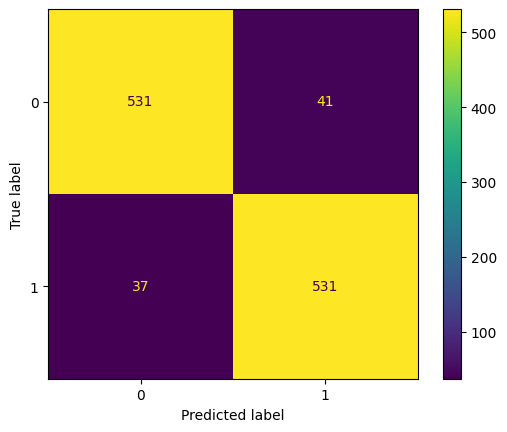

In [105]:
cm = confusion_matrix(y_test, y_pred_best_xg)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

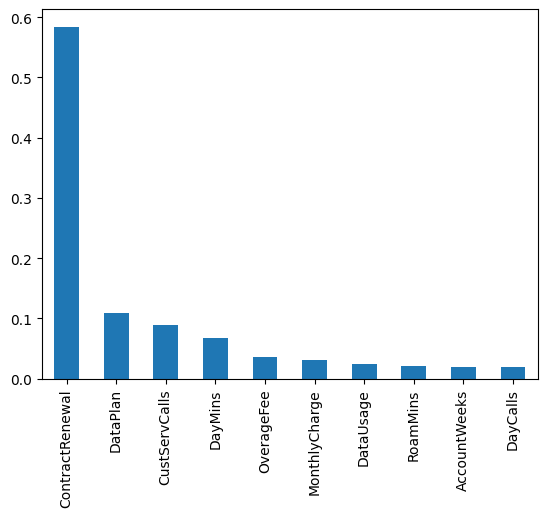

In [106]:
feature_importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();